In [ ]:
#| default_exp lgssystem

# lgssystem
> Define and solve models for LGS systems

## Imports -

In [ ]:
#| hide
from fastcore.test import test_close

In [ ]:
#| export
import importlib
from IPython.display import SVG, Markdown

from pymor.vectorarrays.interface import VectorArray
from pymor.operators.interface import Operator

from pylgs.imports import *
from pylgs.utilities.nbdev import DictTbl, AttributeTbl
from pylgs.utilities.testing import test_array
from pylgs.utilities.sparse import sparse_kronecker_matrix, sparse_toeplitz, sparse_identity, sparse_diag, sparse
from pylgs.utilities.numpy import sym_range
from pylgs.pymor.parameters import *
from pylgs.pymor.vectorarrays import *
from pylgs.pymor.operators import *
from pylgs.pymor.timestepping import *
from pylgs.pymor.grids import *
from pylgs.pymor.models import *
from pylgs.velocitygroups import *
from pylgs.dmelements import *

In [ ]:
#| hide
np.set_printoptions(formatter={'float': lambda x: f'{x:^ 8.2}' if x else f'{0:^ 8}'}, linewidth=140)

## LGSSystem -

In [ ]:
#| export
class LGSSystem(ParametricObject):
    """`LGSSystem` creates numerical models for the chosen laser guide star atomic system."""
    
    block_names = [
        "A_ind", # Part of density-matrix evolution matrix that is independent of atomic velocity
        "A_dop", # Part of density-matrix evolution matrix describing Doppler shift
        "A_rec", # Part of density-matrix evolution matrix describing atomic recoil
        "A_vcc", # Part of density-matrix evolution matrix describing velocity-changing collisions
        "b", # Constant vector in the density-matrix evolution equation describing atomic transit
        "Flux" # Operator giving return flux from each transition
    ]
    
    def __init__(
        self, 
        system:str, # Name of the atomic system to be loaded from file
        fixed_params:dict={} # Values for system parameters that will be held fixed
    ):
        self.path = LGSSystem._get_path(system)
        fixed_params = Mu(fixed_params)
        self.__auto_init(locals())
        for name in self.block_names:
            setattr(
                self, 
                name,
                LincombOperator.from_file(self.path/name).partial_assemble(self.fixed_params).with_(name=name)
            )
        self.parameters = Parameters.of(*(getattr(self, name) for name in self.block_names))
        self.initial = self.Flux.source.from_xarray(
            LincombOperator.from_file(self.path/'b').partial_assemble(Mu(BeamTransitRatePerS=1)).matrix.rename({'Density matrix (range)': 'Density matrix (source)'})
        )
        self.n_variables = self.Flux.source.dim 
        self.dm_elements = self.Flux.assemble().matrix['Density matrix (source)']
        self.level_population = level_population(self.dm_elements)
        self.population = population(self.dm_elements) 
        self.total_population = sum_over_dm(self.dm_elements) * self.population

### _is_valid_dir -

In [ ]:
#|export
@patch(cls_method=True)
def _is_valid_dir(cls:LGSSystem, dir):
    """Check if the supplied directory has the required files to define an LGSSystem."""
    dir = Path(dir)
    if not dir.is_dir(): return False
    files = {f.name for f in dir.glob("*.mtxn")}
    required_files = {'A_dop.mtxn', 'A_ind.mtxn', 'A_rec.mtxn', 'A_vcc.mtxn', 'Flux.mtxn', 'b.mtxn'}
    return required_files <= files

### builtins -

In [ ]:
#|export
@patch(cls_method=True)
def _builtin_paths(cls:LGSSystem):
    return [dir for dir in importlib.resources.files("pylgs.systems").iterdir() if LGSSystem._is_valid_dir(dir)]

In [ ]:
#|export
@patch(cls_method=True)
def builtins(cls:LGSSystem):
    return [dir.name for dir in LGSSystem._builtin_paths()]

List the available LGS systems:

In [ ]:
LGSSystem.builtins()

['NaD1', 'Na330', 'NaD2', 'NaD2_Repump', 'NaD1_Toy']

### _get_path -

In [ ]:
#|export
@patch(cls_method=True)
def _get_path(cls:LGSSystem, name):
    if LGSSystem._is_valid_dir(name): return Path(name)
    for dir in LGSSystem._builtin_paths(): 
        if dir.name == name: return dir
    raise FileNotFoundError(f"{name} does not correspond to a built-in or supplied LGSSystem.")

In [ ]:
#|hide
LGSSystem._get_path("NaD2")

Path('/Users/simon/Development/pyLGS/pylgs/pylgs/systems/NaD2')

### show_diagram -

In [ ]:
#|export
@patch(cls_method=True)
def diagram(
    cls:LGSSystem, 
    name:str | Path, # Name of built-in LGS system definition, or directory of supplied system
    kind="Toy" # "Toy" to show level diagram and pumped transitions, "ToScale" to show hyperfine structure to scale, "NotToScale" to show unscaled hf structure
):
    """Draw a level diagram for the system of the specified kind."""
    return SVG(LGSSystem._get_path(name)/f"LevelDiagram{kind}.svg")

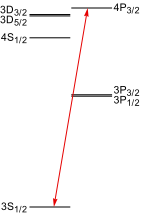

In [ ]:
LGSSystem.diagram("Na330", "Toy")

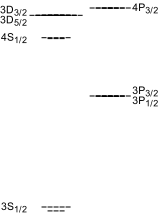

In [ ]:
LGSSystem.diagram("Na330", "ToScale")

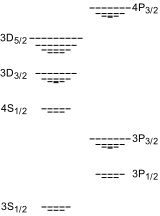

In [ ]:
LGSSystem.diagram("Na330", "NotToScale")

### info -

In [ ]:
#|export
@patch(cls_method=True)
def info(
    cls:LGSSystem, 
    name:str | Path, # Name of built-in LGS system definition, or directory of supplied system
):
    """Display information about LGS system `name`."""
    return Markdown(filename=LGSSystem._get_path(name)/"info.md")

In [ ]:
LGSSystem.info("NaD2_Repump")

#### Atomic levels
$\text{3S}_{\frac{1}{2}}$, $\text{3P}_{\frac{3}{2}}$
#### Pump transitions
1. $\text{3S}_{\frac{1}{2}}\land F=1\to \text{3P}_{\frac{3}{2}}$
1. $\text{3S}_{\frac{1}{2}}\land F=2\to \text{3P}_{\frac{3}{2}}$
#### Transition wavelengths
- $\text{3P}_{\frac{3}{2}}\to \text{3S}_{\frac{1}{2}}$: 589.158 nm
#### Substructure
- Hyperfine structure included
- Zeeman structure included
- 24 total sublevels
#### Density matrix elements
- All populations included
- All Zeeman coherences (between same level and same F) included
- All hyperfine coherences (between same level and different F) neglected
- Optical coherences (between different levels) included for pump transitions only
- 374 density matrix elements total
#### Input parameters
- BeamTransitRatePerS
- BFieldG
- MagneticAzimuthDegrees
- MagneticZenithDegrees
- RecoilParameter
- SDampingCollisionRatePerS
- TemperatureK
- VccRatePerS
- DetuningHz1
- DetuningHz2
- EllipticityDegrees1
- EllipticityDegrees2
- IntensitySI1
- IntensitySI2
- LaserWidthHz1
- LaserWidthHz2
- PolarizationAngleDegrees1
- PolarizationAngleDegrees2

Load a "toy" (no angular momentum) model LGS system and fix values for most of the parameters:

In [ ]:
lgs = LGSSystem(
    'NaD1_Toy',
    fixed_params={'EllipticityDegrees1': 45.0,
                  'PolarizationAngleDegrees1': 0,
                  'DetuningHz1': 0,
                  'LaserWidthHz1': 10.0e6,
                  'BFieldG': 0.5,
                  'MagneticZenithDegrees': 45.0,
                  'MagneticAzimuthDegrees': 45.0,
                  'SDampingCollisionRatePerS': 4e3,
                  'BeamTransitRatePerS': 1e2,
                  'VccRatePerS': 3e4,
                  'TemperatureK': 2e2,
                  'RecoilParameter': 1,
                 }
)

The only remaining parameter is the laser intensity. Here the value 1 indicates that the parameter is a scalar quantity:

In [ ]:
lgs.parameters

Parameters({IntensitySI1: 1})

In [ ]:
#| hide
#| echo: false
# AttributeTbl(LGSSystem)

Define a value for the intensity to use for the following examples:

In [ ]:
mu = Mu(IntensitySI1=46.)

## Operators -

### _reaction -


In [ ]:
#| export
@patch
def _reaction(self:LGSSystem, vg:VelocityGroups):
    return vg.identity() * self.A_ind + vg.velocity_diagonal() * self.A_dop

In [ ]:
#|hide
vg = VelocityGroups(2)
vg

{'VGCenter': array([  -1.5  ,    1.5  ]),
 'VGDensity': array([   0.5  ,    0.5  ]),
 'VGWidth': array([   3.0  ,    3.0  ]),
 'VGInverseWidth': array([  0.33  ,   0.33  ]),
 'VGNumber': 2,
 'velocity_groups': array([   1.0  ,    1.0  ])}

In [ ]:
#| hide
op = lgs._reaction(vg)
op

LincombOperator(
    (ProductOperator(
         [XarrayMatrixOperator(
              <xarray.DataArray (Atomic velocity (range): 2, Atomic velocity: 2)> Size: 48B
              <COO: shape=(2, 2), dtype=float64, nnz=2, fill_value=0.0>
              Coordinates:
                * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
                * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5,
              source=XarrayVectorSpace(
                         coords=Coordinates:
                                  * Atomic velocity  (Atomic velocity) float64 16B -1.5 1.5),
              range=XarrayVectorSpace(
                        coords=Coordinates:
                                 * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5)),
          LincombOperator(
              (XarrayMatrixOperator(
                   <xarray.DataArray 'A_ind' (Density matrix (range): 4, Density matrix (source): 4)> Size: 120B
                   <COO: shape=(4, 4), dtype=float64, nnz=5, fill_value=0.0>
                   Coordinates:
                     * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...
                     * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...,
                   source=XarrayVectorSpace(
                              coords=Coordinates:
                                       * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
                   range=XarrayVectorSpace(
                             coords=Coordinates:
                                      * Density matrix (range)  (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S<...,
                             name='A_ind'),
                   name='A_ind'),
               XarrayMatrixOperator(
                   <xarray.DataArray 'A_ind' (Density matrix (range): 4, Density matrix (source): 4)> Size: 96B
                   <COO: shape=(4, 4), dtype=float64, nnz=4, fill_value=0.0>
                   Coordinates:
                     * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...
                     * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...,
                   source=XarrayVectorSpace(
                              coords=Coordinates:
                                       * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
                   range=XarrayVectorSpace(
                             coords=Coordinates:
                                      * Density matrix (range)  (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S<...,
                             name='A_ind'),
                   name='A_ind')),
              (1.0, ExpressionParameterFunctional('3890540.1450507678*sqrt(IntensitySI1)', {IntensitySI1: 1})),
              name='A_ind')]),
     ProductOperator(
         [XarrayMatrixOperator(
              <xarray.DataArray (Atomic velocity (range): 2, Atomic velocity: 2)> Size: 32B
              <COO: shape=(2, 2), dtype=float64, nnz=2, fill_value=0.0>
              Coordinates:
                * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
                * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5,
              source=XarrayVectorSpace(
                         coords=Coordinates:
                                  * Atomic velocity  (Atomic velocity) float64 16B -1.5 1.5),
              range=XarrayVectorSpace(
                        coords=Coordinates:
                                 * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5)),
          XarrayMatrixOperator(
              <xarray.DataArray 'A_dop' (Density matrix (range): 4, Density matrix (source): 4)> Size: 48B
              <COO: shape=(4, 4), dtype=float64, nnz=2, fill_value=0.0>
              Coordinates:
                * Density matrix (range)   (Density matrix (range))

In [ ]:
#| hide
mat = to_matrix(op.assemble(mu))
mat.toarray()/1e6

array([[ -0.03  ,     0   ,  2.6e+01,  6.1e+01,     0   ,     0   ,     0   ,     0   ],
       [    0   , -6.2e+01,  6.1e+03,     0   ,     0   ,     0   ,     0   ,     0   ],
       [-1.3e+01, -6.1e+03, -6.2e+01,  1.3e+01,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   , -2.6e+01, -6.1e+01,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,  -0.03  ,     0   ,  2.6e+01,  6.1e+01],
       [    0   ,     0   ,     0   ,     0   ,     0   , -6.2e+01, -6.1e+03,     0   ],
       [    0   ,     0   ,     0   ,     0   , -1.3e+01,  6.1e+03, -6.2e+01,  1.3e+01],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   , -2.6e+01, -6.1e+01]])

In [ ]:
#| hide
test_array('core', '_reaction', _)

In [ ]:
#| hide
op.source

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5
             * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...)

In [ ]:
#| hide
op.range

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
             * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...,
    name='A_ind')

### _vcc -

In [ ]:
#| export
@patch
def _vcc(self:LGSSystem, vg:VelocityGroups):
    return vg.n_times_1() * self.A_vcc

In [ ]:
#| hide
op = lgs._vcc(vg)

In [ ]:
#| hide
op

ProductOperator(
    [XarrayMatrixOperator(
         <xarray.DataArray (Atomic velocity (range): 2, Atomic velocity: 2)> Size: 96B
         <COO: shape=(2, 2), dtype=float64, nnz=4, fill_value=0.0>
         Coordinates:
           * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
           * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5,
         source=XarrayVectorSpace(
                    coords=Coordinates:
                             * Atomic velocity  (Atomic velocity) float64 16B -1.5 1.5),
         range=XarrayVectorSpace(
                   coords=Coordinates:
                            * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5)),
     XarrayMatrixOperator(
         <xarray.DataArray 'A_vcc' (Density matrix (range): 4, Density matrix (source): 4)> Size: 48B
         <COO: shape=(4, 4), dtype=float64, nnz=2, fill_value=0.0>
         Coordinates:
           * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...
           * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...,
         source=XarrayVectorSpace(
                    coords=Coordinates:
                             * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
         range=XarrayVectorSpace(
                   coords=Coordinates:
                            * Density matrix (range)  (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S<...,
                   name='A_vcc'),
         name='A_vcc')])

In [ ]:
#| hide
op.source

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5
             * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...)

In [ ]:
#| hide
op.range

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
             * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...,
    name='A_vcc')

In [ ]:
#| hide
mat = to_matrix(op.assemble(mu))
mat.toarray()/10000

array([[   1.5  ,     0   ,     0   ,     0   ,    1.5  ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,    1.5  ,     0   ,     0   ,     0   ,    1.5  ],
       [   1.5  ,     0   ,     0   ,     0   ,    1.5  ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,    1.5  ,     0   ,     0   ,     0   ,    1.5  ]])

In [ ]:
#| hide
test_array('core', '_vcc', _)

### _recoil -

In [ ]:
#| export
@patch
def _recoil(self:LGSSystem, vg:VelocityGroups):
    return vg.drho_dv() * self.A_rec

In [ ]:
#| hide
op = lgs._recoil(vg)
op

ProductOperator(
    [XarrayMatrixOperator(
         <xarray.DataArray (Atomic velocity (range): 2, Atomic velocity: 2)> Size: 48B
         <COO: shape=(2, 2), dtype=float64, nnz=3, fill_value=0.0>
         Coordinates:
           * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
           * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5,
         source=XarrayVectorSpace(
                    coords=Coordinates:
                             * Atomic velocity  (Atomic velocity) float64 16B -1.5 1.5),
         range=XarrayVectorSpace(
                   coords=Coordinates:
                            * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5)),
     XarrayMatrixOperator(
         <xarray.DataArray 'A_rec' (Density matrix (range): 4, Density matrix (source): 4)> Size: 24B
         <COO: shape=(4, 4), dtype=float64, nnz=1, fill_value=0.0>
         Coordinates:
           * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...
           * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...,
         source=XarrayVectorSpace(
                    coords=Coordinates:
                             * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
         range=XarrayVectorSpace(
                   coords=Coordinates:
                            * Density matrix (range)  (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S<...,
                   name='A_rec'),
         name='A_rec')])

In [ ]:
#| hide
op.source

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5
             * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...)

In [ ]:
#| hide
op.range

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
             * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...,
    name='A_rec')

In [ ]:
#| hide
to_matrix(op, mu=mu).toarray()

array([[    0   ,     0   ,     0   , -1.6e+03,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,  1.6e+03,     0   ,     0   ,     0   , -1.6e+03],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ,     0   ]])

In [ ]:
#| hide
test_array('core', '_rec', _)

### operator -

In [ ]:
#| export
@patch
def operator(
    self:LGSSystem, 
    vg:VelocityGroups # `VelocityGroups` specification
)->Operator:
    """The evolution operatior for the system, given the `VelocityGroups` `vg`."""
    return (-1 * (self._reaction(vg) + self._vcc(vg) + self._recoil(vg))).with_(
        name='Density matrix',
        solver_options={'inverse': {'type': 'scipy_lgmres_spilu', 'preconditioner_bandwidth': self.n_variables}}
    )

Form the operator with the example `VelocityGroups`:

In [ ]:
op = lgs.operator(vg)

In [ ]:
#| hide
op.solver_options['inverse']['preconditioner_bandwidth']

4

The operator operates on vectors from the $2\times4$ (velocity $\times$ density matrix) product vector space:

In [ ]:
op.source

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5
             * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...)

And returns a vector from the same space:

In [ ]:
op.range

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
             * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...,
    name='A_ind')

Substitute the free parameter values into the operator and write it explicitly as a block matrix, with $2\times2$ blocks for the velocity space, each block being $4\times4$ on the density matrix space:

In [ ]:
to_matrix(op, mu=mu).toarray()/1e6

array([[  0.015 ,     0   , -2.6e+01, -6.1e+01,  -0.015 ,     0   ,     0   ,     0   ],
       [    0   ,  6.2e+01, -6.1e+03,     0   ,     0   ,     0   ,     0   ,     0   ],
       [ 1.3e+01,  6.1e+03,  6.2e+01, -1.3e+01,     0   ,     0   ,     0   ,     0   ],
       [    0   ,     0   ,  2.6e+01,  6.1e+01,     0   ,     0   ,     0   ,  -0.015 ],
       [ -0.015 ,     0   ,     0   , -0.0016 ,   0.015 ,     0   , -2.6e+01, -6.1e+01],
       [    0   ,     0   ,     0   ,     0   ,     0   ,  6.2e+01,  6.1e+03,     0   ],
       [    0   ,     0   ,     0   ,     0   ,  1.3e+01, -6.1e+03,  6.2e+01, -1.3e+01],
       [    0   ,     0   ,     0   ,  -0.015 ,     0   ,     0   ,  2.6e+01,  6.1e+01]])

In [ ]:
#| hide
test_array('core', 'operator', _)

### rhs -

In [ ]:
#| export
@patch
def rhs(
    self:LGSSystem, 
    vg:VelocityGroups # `VelocityGroups` specification
)->VectorArray:
    """The right-hand side vector for this system given the `VelocityGroups` `vg`."""
    return velocity_density_vector(vg).rename({'Atomic velocity': 'Atomic velocity (range)'}) * self.b.as_range_array()

Form the right-hand side `VectorArray`:

In [ ]:
vec = lgs.rhs(vg)

The vector is in the $2\times4$ (velocity $\times$ density matrix) product vector space:

In [ ]:
vec.space

XarrayVectorSpace(
    coords=Coordinates:
             * Atomic velocity (range)  (Atomic velocity (range)) float64 16B -1.5 1.5
             * Density matrix (range)   (Density matrix (range)) <U50 800B 'ρ<sub>Re, 3S...,
    name='XarrayVectorArray')

In [ ]:
vec.space.shape

(2, 4)

Write as a flattened 1D vector:

In [ ]:
vec.to_numpy()

array([[  5e+01 ,     0   ,     0   ,     0   ,   5e+01 ,     0   ,     0   ,     0   ]])

In [ ]:
test_array('core', 'rhs', _)

### _initial_dm -


In [ ]:
#| export
@patch
def _initial_dm(self:LGSSystem, vg):
    return velocity_density_vector(vg) * self.initial

In [ ]:
#| hide
vec = lgs._initial_dm(vg)
vec

XarrayVectorArray(
    XarrayVectorSpace(
        coords=Coordinates:
                 * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5
                 * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...,
        name='XarrayVectorArray'),
    XarrayVectorArrayImpl(
        <xarray.DataArray 'XarrayVectorArray' (Atomic velocity: 2,
                                               Density matrix (source): 4, none: 1)> Size: 64B
        <COO: shape=(2, 4, 1), dtype=float64, nnz=2, fill_value=0.0>
        Coordinates:
          * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5
          * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...
          * none                     (none) <U4 16B 'none',
        <xarray.DataArray 'XarrayVectorArray' (Atomic velocity: 2,
                                               Density matrix (source): 4)> Size: 64B
        array([[    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ]])
        Coordinates:
          * Atomic velocity          (Atomic velocity) float64 16B -1.5 1.5
          * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
    _len=1)

In [ ]:
#| hide
vec.dim

8

In [ ]:
#| hide
vec.array

Format,coo
Data Type,float64
Shape,"(2, 4, 1)"
nnz,2
Density,0.25
Read-only,True
Size,64
Storage ratio,1.00


In [ ]:
#| hide
vec.to_numpy()

array([[   0.5  ,     0   ,     0   ,     0   ,    0.5  ,     0   ,     0   ,     0   ]])

In [ ]:
test_array('core', '_initial_dm', _)

In [ ]:
#| hide
test_close(np.sum(vec.to_numpy()), 1., eps=1e-4)

### _products -


In [ ]:
#| export
@patch
def _products(self:LGSSystem, vg): 
    return {
        'population': self.total_population, # Fraction of total atomic population in each velocity group
        'total_population': vg.sum() * self.total_population, # Total atomic population (should equal 1)
        'population_distribution': vg.normalize() * self.total_population, # Atomic population per unit velocity interval
        'level_population': self.level_population, # Population of each atomic level in each velocity group
        'total_level_population': vg.sum() * self.level_population, # Total atomic population in each level
        'level_population_distribution': vg.normalize() * self.level_population, # Level population per unit velocity interval
        'flux': self.Flux, # Return flux on each transition from each velocity group
        'total_flux': vg.sum() * self.Flux, # Total return flux
        'flux_distribution': vg.normalize() * self.Flux, # Return flux per unit velocity interval
        'velocity_sum': vg.sum(), # Sum over velocity groups
        'velocity_normalize': vg.normalize(), # Normalize by velocity-group width
    }

## Models -

### stationary_model -


In [ ]:
#| export
@patch
def stationary_model(
    self:LGSSystem, 
    vg:int|Iterable|VelocityGroups=6, # Specification of velocity groups 
    # output='total_flux' # Operator to be applied to solution to obtain the output
) -> StationaryModel: # Model for the steady-state LGS system
    """Return a pyMOR `StationaryModel` for the steady state cw LGS system."""
    vg = VelocityGroups(vg)
    return StationaryModel(
        self.operator(vg), 
        self.rhs(vg), 
        products=self._products(vg),
        data={
            'velocity_groups': vg,
            'grid': OnedUnstructuredGrid(vg.edges)
        }
    )

An integer can be supplied for `vg` to get that many evenly spaced velocity groups:

In [ ]:
model = lgs.stationary_model(vg=30)

Solve the model and calculate the return flux by supplying values for all free parameters:

In [ ]:
model.total_flux({'IntensitySI1': 1e3}).item()

52423.693460667244

In [ ]:
#| hide
test_close(_, 52423.69346066604)

Solve the model and return the steady-state density matrix:

In [ ]:
sol = model.solve({'IntensitySI1': 1e3})

The solution can be visualized in several ways. Plot the flux for each velocity bin:

In [ ]:
#|notest
model.flux(sol).visualize()

Plot the real and imaginary parts of the density-matrix elements for each velocity bin:

In [ ]:
#|notest
sol.visualize()

Plot just the level populations:

In [ ]:
#|notest
model.level_population(sol).visualize()

Plot the total atomic population:

In [ ]:
#|notest
model.population(sol).visualize()

Note that the above visualizations plot the contribution to the quantity from each velocity group. If the velocity groups are not all of the same width, this will cause the plots to appear distorted. In this case one can instead plot the velocity distribution of the quantities using `flux_distribution`, `population_distribution`, etc. To plot the velocity distribution of the density-matrix elements, use `velocity_normalize(sol)`.

In [ ]:
#| tbl-cap: Operators that can be applied to the solution of an LGS model
#| label: tbl-output_operators
#| echo: false
DictTbl(LGSSystem._products)

|   | **Description** |
| - | --------------- |
| population | Fraction of total atomic population in each velocity group |
| total_population | Total atomic population (should equal 1) |
| population_distribution | Atomic population per unit velocity interval |
| level_population | Population of each atomic level in each velocity group |
| total_level_population | Total atomic population in each level |
| level_population_distribution | Level population per unit velocity interval |
| flux | Return flux on each transition from each velocity group |
| total_flux | Total return flux |
| flux_distribution | Return flux per unit velocity interval |
| velocity_sum | Sum over velocity groups |
| velocity_normalize | Normalize by velocity-group width |

Check that the atomic population summed over all velocity groups is approximately 1:

In [ ]:
model.total_population(sol).item()

0.9933933945227537

In [ ]:
#| hide
test_close(_, 1., eps=.01)

### adaptive_stationary_model -


In [ ]:
#| export
@patch
def adaptive_stationary_model(
    self:LGSSystem, 
    mu, # Parameter values to use during velocity-group refinement
    vg=6, # Initial velocity groups
    max_weight=0.01 # Maximum fraction of the return flux from any one velocity group
)->StationaryModel: # Steady-state LGS model with more velocity groups in regions that produce more return flux
    """Create a `StationaryModel` with narrower velocity bins in velocity regions with higher flux."""
    vg = VelocityGroups(vg)
    while True:
        m = self.stationary_model(vg)
        u = m.solve(mu)
        o = m.flux(u).array.sum('Transition').squeeze().data
        o /= np.sum(o)
        mask = o > max_weight
        if not np.sum(mask):
            break
        vg = vg.subdivide(mask)
    return self.stationary_model(vg)

Create a model with adaptively refined velocity groups using a particular value for the intensity parameter during refinement: 

In [ ]:
model = lgs.adaptive_stationary_model({'IntensitySI1': 1e3}, max_weight=0.2)

Solve and find total flux:

In [ ]:
model.total_flux({'IntensitySI1': 1e3}).item()

91313.76877884821

In [ ]:
#| hide
test_close(_, 91313.76877884942)

Solve for the density matrix. The solution has density-matrix values for 17 velocity groups:

In [ ]:
sol = model.solve({'IntensitySI1': 1e3})
sol

XarrayVectorArray(
    XarrayVectorSpace(
        coords=Coordinates:
                 * Atomic velocity          (Atomic velocity) float64 136B -2.5 -1.5 ... 2.5
                 * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
    XarrayVectorArrayImpl(
        <xarray.DataArray (Atomic velocity: 17, Density matrix (source): 4)> Size: 544B
        array([[ 0.0023 , -1.4e-05, -8.6e-08,  1.9e-07],
               [  0.076 , -0.00077, -7.8e-06,  1.6e-05],
               [  0.16  , -0.0032 , -6.6e-05,  0.00013],
               [  0.12  , -0.0049 , -0.0002 ,  0.0004 ],
               [  0.066 , -0.0052 , -0.00043,  0.00086],
               [  0.031 , -0.0046 , -0.00075,  0.0015 ],
               [  0.011 , -0.0026 , -0.00087,  0.0017 ],
               [ 0.0066 , -0.0017 , -0.0016 ,  0.0033 ],
               [ 0.0032 ,  0.0005 , -0.00099,   0.002 ],
               [ 0.0056 ,  0.0016 ,  -0.001 ,  0.0021 ],
               [  0.02  ,  0.0048 , -0.0016 ,  0.0031 ],
               [  0.043 ,  0.0065 , -0.0011 ,  0.0021 ],
               [  0.071 ,  0.0056 , -0.00046,  0.00092],
               [  0.12  ,  0.0049 , -0.0002 ,  0.0004 ],
               [  0.16  ,  0.0032 , -6.6e-05,  0.00013],
               [  0.076 ,  0.00077, -7.8e-06,  1.6e-05],
               [ 0.0023 ,  1.4e-05, -8.6e-08,  1.9e-07]])
        Coordinates:
          * Atomic velocity          (Atomic velocity) float64 136B -2.5 -1.5 ... 2.5
          * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...,
        <xarray.DataArray (Atomic velocity: 17, Density matrix (source): 4)> Size: 544B
        array([[    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ],
               [    0   ,     0   ,     0   ,     0   ]])
        Coordinates:
          * Atomic velocity          (Atomic velocity) float64 136B -2.5 -1.5 ... 2.5
          * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
    _len=1)

Plot the velocity distribution of flux. Each point marks the center of a velocity group:

In [ ]:
#|notest
model.flux_distribution(sol).visualize(markers=True)

Velocity distribution of the density matrix:

In [ ]:
#|notest
model.velocity_normalize(sol).visualize()

Of the total population:

In [ ]:
#|notest
model.population_distribution(sol).visualize()

Of the level populations:

In [ ]:
#|notest
model.level_population_distribution(sol).visualize()

### instationary_model -


In [ ]:
#| export
@patch
def instationary_model(
    self:LGSSystem, 
    vg:int|Iterable|VelocityGroups=6, # Specification of velocity groups 
    # output:str='total_flux',  # Operator to be applied to solution to obtain the output
    T=1.e-6, # Final time (seconds)
    num_values=100, # Number of time step values to return
    initial_rho=None, # Initial density matrix. `None` means to use the thermal distribution
    time_stepper=BDFTimeStepper() # Solver to use
) -> InstationaryModel: # Model for the LGS system dynamics
    """Create an `InstationaryModel` for the LGS system dynamics."""
    vg = VelocityGroups(vg)
    return InstationaryModel(
        T,
        ifnone(initial_rho, self._initial_dm(vg)),
        self.operator(vg), 
        self.rhs(vg), 
        mass=None,
        time_stepper=time_stepper,
        num_values=num_values,
        # output_functional=self._products(vg)[output],
        products=self._products(vg),
        data={
            'velocity_groups': vg,
            'grid': OnedUnstructuredGrid(vg.edges)
        }
    )

An instationary model with 30 velocity groups:

In [ ]:
model = lgs.instationary_model(
    vg=30, 
    T=1.e-4, 
    num_values=20
)

The BDF solver is efficient but can be very sensitive to the absolute and relative tolerance values. Set appropriate values for this problem:

In [ ]:
pymor.basic.set_defaults({
    'pylgs.pymor.timestepping.cvode_solver_options.cvode_bdf_atol': 1e-3,
    'pylgs.pymor.timestepping.cvode_solver_options.cvode_bdf_rtol': 1e-5
})

Solve for a constant value of intensity:

In [ ]:
sol = model.solve({'IntensitySI1': 1e3})

FloatProgress(value=0.0, bar_style='info', max=0.0001)

Visualize the total flux as a function of time:

In [ ]:
#|notest
model.total_flux(sol).visualize()

Plot the density matrix elements as a function of atomic velocity and animate as a function of time:

In [ ]:
#|notest
model.velocity_normalize(sol).visualize().update_layout(sliders=[dict(active=4)])

Animate the population distribution as a function of time:

In [ ]:
#|notest
model.population_distribution(sol).visualize()

Animate the level population distributions:

In [ ]:
#|notest
model.level_population_distribution(sol).visualize()

Set a shorter evolution time for the model:

In [ ]:
model = model.with_(T=.3e-7, num_values=20)

Solve the model with a modulated intensity parameter:

In [ ]:
sol = model.solve({'IntensitySI1': "5000.*sin(1.e8*t)**2"})

FloatProgress(value=0.0, bar_style='info', max=3e-08)

Visualize the total flux as a function of time:

In [ ]:
#|notest
model.total_flux(sol).visualize()

Visualize the density matrix elements:

In [ ]:
#|notest
model.velocity_normalize(sol).visualize()

Visualize the flux distribution:

In [ ]:
#|notest
model.flux_distribution(sol).visualize()

In [ ]:
#|notest
model.population_distribution(sol).visualize()

### stationary_floquet_model -


In [ ]:
#| export
@patch
def _floquet_products(self:LGSSystem, vg, n_vector, T): 
    return {
        'reconstruct': floquet_reconstruction(n_vector, T),
        # 'total_population': velocity_sum(vg) * self.total_population, 
        # 'population_distribution': velocity_normalize(vg) * self.total_population, 
        'reconstructed_level_population': floquet_reconstruction(n_vector, T) * vg.sum() * self.level_population, 
        # 'level_population_distribution': velocity_normalize(vg) * self.level_population, 
        # 'flux': self.flux,
        # 'flux_distribution': velocity_normalize(vg) * self.flux,
        'reconstructed_total_flux': floquet_reconstruction(n_vector, T) * (vg.sum() * self.Flux),
        # 'velocity_sum': velocity_sum(vg),
        # 'velocity_normalize': velocity_normalize(vg),
    }

In [ ]:
#| export
@patch
def stationary_floquet_model(
    self:LGSSystem, 
    mu, # Parameter specification for parameters modulated at a frequency `nu` 
    T, # List of time values to use for reconstruction
    n_vector, # Number of terms in the system Fourier series
    nu:str='nu', # Name of the frequency variable
    n_operator=None, # Number of terms in the operator Fourier series. `None` defaults to `n_vector` - 1
    vg:int|Iterable|VelocityGroups=6, # Specification of velocity groups
) -> StationaryFloquetModel: # Model for the Fourier coefficients of the periodic LGS system
    """Return a `StationaryFloquetModel` for the Fourier coefficients of the periodic state of a modulated LGS system."""
    vg = VelocityGroups(vg)
    return StationaryFloquetModel(
        self.operator(vg), 
        self.rhs(vg), 
        mu,
        nu=nu,
        n_vector=n_vector,
        n_operator=n_operator,
        products=self._products(vg) | self._floquet_products(vg, n_vector, T),
        data={
            'velocity_groups': vg,
            'grid': OnedUnstructuredGrid(vg.edges)
        }
    )

The `StationaryFloquetModel` solves for the periodic state of a modulated system after the transient dynamics have died out.

Build a stationary Floquet model for six Fourier harmonics of a system with sinusoidally modulated intensity:

In [ ]:
model = lgs.stationary_floquet_model(
    {'IntensitySI1': "5000.*sin(nu*t)**2"},
    T=np.linspace(0, 1e-7, 20),
    n_vector=3,
    vg=30
)

Define values for the modulation frequency and light detuning:

In [ ]:
mu = Mu(nu=1e8, DetuningHz1=0)

Solve for the periodic state. The solution contains 13 Fourier coefficients for each density-matrix element in each velocity group:

In [ ]:
sol = model.solve(mu)
sol

XarrayVectorArray(
    XarrayVectorSpace(
        coords=Coordinates:
                 * Fourier coefficient      (Fourier coefficient) int64 56B -3 -2 -1 0 1 2 3
                 * Atomic velocity          (Atomic velocity) float64 240B -2.9 -2.7 ... 2.9
                 * Density matrix (source)  (Density matrix (source)) <U50 800B 'ρ<sub>Re, 3...),
    XarrayVectorArrayImpl(
        <xarray.DataArray (Fourier coefficient: 7, Atomic velocity: 30,
                           Density matrix (source): 4)> Size: 13kB
        array([[[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
        ...
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j],
                [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
                  0.00000000e+00+0.00000000e+00j]]])
        Coordinates:
          * Fourier coefficient      (Fourier coefficient) int64 56B -3 -2 -1 0 1 2 3
          * Atomic 

The real and imaginary parts of the Fourier coefficients of the time-dependent return flux:

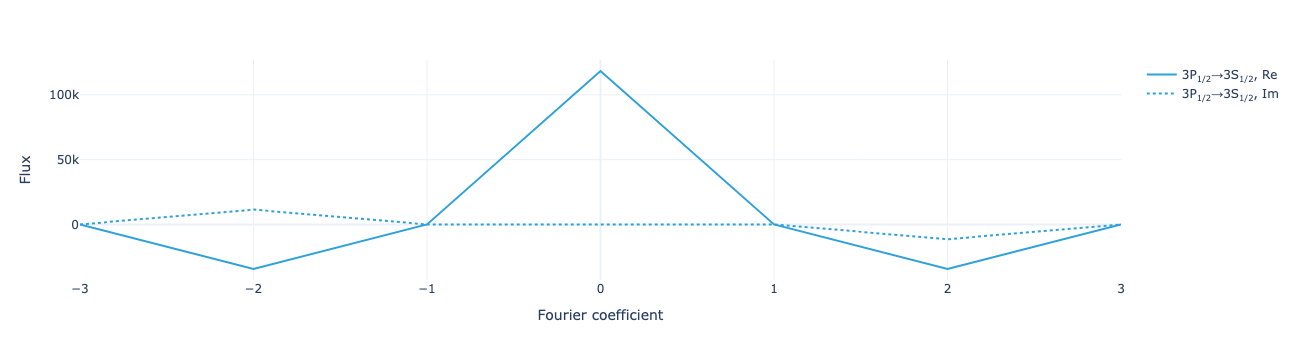

In [ ]:
#|notest
model.total_flux(sol).visualize()

The total return flux reconstructed as a function of time:

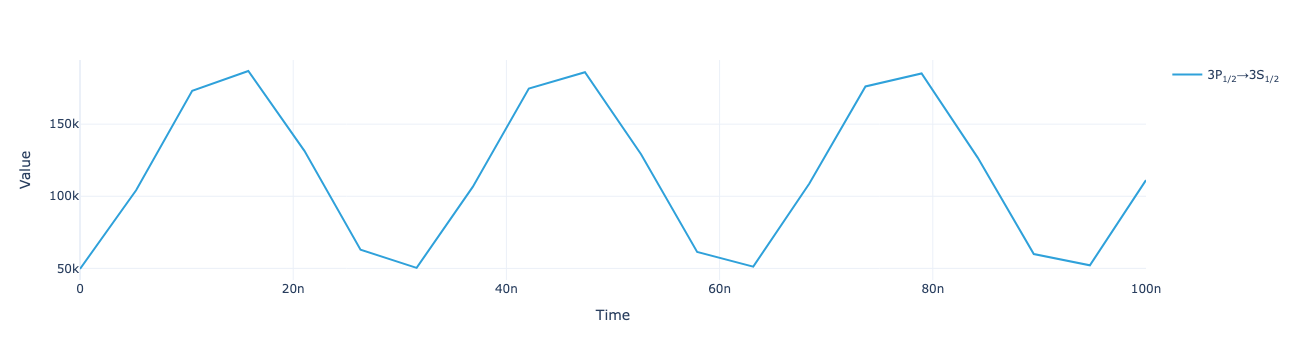

In [ ]:
#|notest
model.reconstructed_total_flux(sol, mu).real.visualize()

The real and imaginary parts of the Fourier coefficients of the real and imaginary parts of the density-matrix elements:

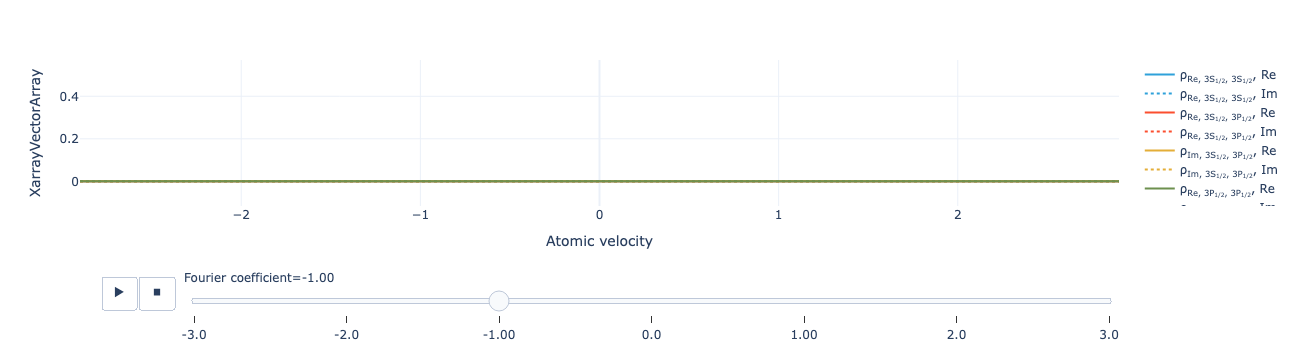

In [ ]:
#|notest
model.velocity_normalize(mu).visualize()

The real and imaginary parts of the density-matrix elements reconstructed as a function of time:

In [ ]:
#|notest
model.velocity_normalize(model.reconstruct(mu)).real.visualize()

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()